# Mdl01_test_interactive_pipeline
- adjust PoC codes to PlantVillage dataset and 0/1 task

In [5]:
from typing import List, Text
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils
import tensorflow_hub as hub

from tfx import v1 as tfx
from tfx_bsl.public import tfxio

2024-11-01 14:44:03.111955: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 14:44:03.167665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 14:44:03.167720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 14:44:03.169698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 14:44:03.180505: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 14:44:03.181768: I tensorflow/core/platform/cpu_feature_guard.cc:1

### write module file including preprocessing_fn

In [6]:
_module_file = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/modules/utils.py'

In [112]:
%%writefile {_module_file}
from typing import List, Text
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils
import tensorflow_hub as hub
import tensorflow_model_analysis as tfma
from tensorflow_model_analysis.metrics import Metric

from tfx import v1 as tfx
from tfx_bsl.public import tfxio

_FEATURE_KEY = 'image_raw'
_LABEL_KEY = 'label'

_FEATURE_KEYS = ['image_raw',]

_TRAIN_BATCH_SIZE = 100
_EVAL_BATCH_SIZE = 20

_IMG_HEIGHT = 299
_IMG_WIDTH = 299

class CustomF1Score(tf.keras.metrics.Metric):
	def __init__(self, name='custom_f1_score', **kwargs):
		super().__init__(name=name, **kwargs)
		self.f1_score = tf.keras.metrics.F1Score()
	
	def update_state(self, y_true, y_pred, sample_weight=None):
		self.f1_score.update_state(y_true, y_pred, sample_weight)
	    
	def result(self):
		return self.f1_score.result()
	
	def reset_state(self):
		self.f1_score.reset_states()

# TFX Transform will call this function
def preprocessing_fn(inputs):
	outputs = {}
	
	raw_image_dataset = tf.sparse.to_dense(inputs[_FEATURE_KEY])
	image_tensor = tf.map_fn(
		fn=lambda x : tf.image.resize(
			tf.image.convert_image_dtype(
                tf.io.decode_image(x[0], dtype=tf.float32, channels=3, expand_animations=False),
                dtype=tf.float32
            ),
			[_IMG_HEIGHT, _IMG_WIDTH]),
		elems=raw_image_dataset,
		fn_output_signature=tf.TensorSpec((_IMG_HEIGHT, _IMG_WIDTH, 3), dtype=tf.float32, name=None),
		infer_shape = True)
	outputs[_FEATURE_KEY] = image_tensor
	label = tf.sparse.to_dense(inputs[_LABEL_KEY])
	with tf.init_scope():
		table_keys = [0, 1]
		initializer = tf.lookup.KeyValueTensorInitializer(
			keys=table_keys,
			values=tf.cast(tf.range(len(table_keys)), tf.float32),
			key_dtype=tf.int64,
			value_dtype=tf.float32)
		table = tf.lookup.StaticHashTable(initializer, default_value=-1)
	label = table.lookup(inputs[_LABEL_KEY])
	label = tf.sparse.to_dense(label)
	label = tf.reshape(label, [-1])
	outputs[_LABEL_KEY] = label
	
	return outputs

def _apply_preprocessing(raw_features, tft_layer):
	transformed_features = tft_layer(raw_features)
	if _LABEL_KEY in raw_features:
		transformed_label = transformed_features.pop(_LABEL_KEY)
		return transformed_features, transformed_label
	else:
		return transformed_features, None

def _get_serve_tf_examples_fn(model, tf_transform_output):
	model.tft_layer = tf_transform_output.transform_features_layer()
	@tf.function(input_signature=[
	  tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
	])
	def serve_tf_examples_fn(serialized_tf_examples):
		feature_spec = tf_transform_output.raw_feature_spec()
		required_feature_spec = {
			k: v for k, v in feature_spec.items() if k in _FEATURE_KEYS
		}
		parsed_features = tf.io.parse_example(serialized_tf_examples,
											  required_feature_spec)
		transformed_features, _ = _apply_preprocessing(parsed_features,
													   model.tft_layer)
		return model(transformed_features)

	return serve_tf_examples_fn


def _input_fn(file_pattern: List[Text],
			  data_accessor: tfx.components.DataAccessor,
			  tf_transform_output: tft.TFTransformOutput,
			  batch_size: int = 100) -> tf.data.Dataset:
	dataset = data_accessor.tf_dataset_factory(
		file_pattern,
		tfxio.TensorFlowDatasetOptions(batch_size=batch_size),
		schema=tf_transform_output.raw_metadata.schema)

	transform_layer = tf_transform_output.transform_features_layer()
	def apply_transform(raw_features):
		return _apply_preprocessing(raw_features, transform_layer)

	return dataset.map(apply_transform).repeat()


def _freeze_model_by_percentage(model: tf.keras.Model, percentage: float):
	if percentage < 0 or percentage > 1:
		raise ValueError('Freeze percentage should between 0.0 and 1.0')
		
	if not model.trainable:
		raise ValueError(
			'The model is not trainable, please set model.trainable to True')
		
	num_layers = len(model.layers)
	num_layers_to_freeze = int(num_layers * percentage)
	for idx, layer in enumerate(model.layers):
		if idx < num_layers_to_freeze:
			layer.trainable = False
		else:
			layer.trainable = True

def _build_keras_model() -> tf.keras.Model:
	inputs = [
		keras.layers.Input(shape=(_IMG_HEIGHT, _IMG_WIDTH, 3), name=_FEATURE_KEY)
	]
	GCS_MODEL_PATH = "gs://mlpipelineportfolio_bucket_01/for_production/tfhub_models/inception_v3_feature_vector/extracted"
	
	feature_extractor_layer = hub.KerasLayer(
		GCS_MODEL_PATH,
		input_shape=(_IMG_HEIGHT, _IMG_WIDTH, 3),
		trainable=False
	)
	
	model = tf.keras.Sequential([
		keras.layers.Input(shape=(_IMG_HEIGHT, _IMG_WIDTH, 3), name=_FEATURE_KEY),
		feature_extractor_layer,
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Dense(1),
		tf.keras.layers.Activation('sigmoid')
	])
	
	model.compile(
		optimizer=keras.optimizers.Adam(1e-2),
		loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False),
		metrics=[CustomF1Score()])
	
	model.summary(print_fn=logging.info)
	return model

# TFX Trainer will call this function
def run_fn(fn_args: tfx.components.FnArgs):
	tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
	
	train_dataset = _input_fn(
		fn_args.train_files,
		fn_args.data_accessor,
		tf_transform_output,
		batch_size=_TRAIN_BATCH_SIZE)
	eval_dataset = _input_fn(
		fn_args.eval_files,
		fn_args.data_accessor,
		tf_transform_output,
		batch_size=_EVAL_BATCH_SIZE)
	
	model = _build_keras_model()
	model.fit(
		train_dataset,
		steps_per_epoch=fn_args.train_steps,
		validation_data=eval_dataset,
		validation_steps=fn_args.eval_steps)
	
	signatures = {
		'serving_default': _get_serve_tf_examples_fn(model, tf_transform_output),
	}
	model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Overwriting /home/jupyter/SimpleMLPIpeline/uploadFromGitHub/modules/utils.py


### Try using code in InteractiveContext
insert StatisticsGen and SchemaGen in between; it doesn't seem to take long to add them

In [113]:
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.components import ImportExampleGen, StatisticsGen, SchemaGen, Transform, Trainer, Evaluator
import os

#### ExampleGen

In [114]:
context = InteractiveContext(pipeline_name='testing-evaluator-customf1score')

# input_base = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/tfrecord/with_str_label'
# input_base = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/tfrecord/cifar10-2class/with_str_label/'
# input_base = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/tfrecord/plantvillage-5percent/with_str_label/'
input_base_train = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/tfrecord/plantvillage-train-15percent/'
example_gen = ImportExampleGen(input_base=input_base_train)

context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

#### StatisticsGen

In [115]:
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [116]:
context.show(statistics_gen.outputs['statistics'])

#### SchemaGen

In [117]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)  # Transformでresizeするのでschemaには加えない
context.run(schema_gen)


ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [118]:
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image_raw',BYTES,required,single,-
'label',INT,required,single,-


#### Transform

In [119]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=_module_file)
context.run(transform)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying pipeline.py -> build/lib
copying test.py -> build/lib
copying utils.py -> build/lib
copying prod_def.py -> build/lib
installing to /var/tmp/tmpr37xyf82
running install
running install_lib
copying build/lib/prod_def.py -> /var/tmp/tmpr37xyf82/.
copying build/lib/test.py -> /var/tmp/tmpr37xyf82/.
copying build/lib/pipeline.py -> /var/tmp/tmpr37xyf82/.
copying build/lib/utils.py -> /var/tmp/tmpr37xyf82/.
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info


/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /var/tmp/tmpr37xyf82/./tfx_user_code_Transform-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf-py3.10.egg-info
running install_scripts
creating /var/tmp/tmpr37xyf82/tfx_user_code_Transform-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf.dist-info/WHEEL
creating '/var/tmp/tmpdw9druo9/tfx_user_code_Transform-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf-py3-none-any.whl' and adding '/var/tmp/tmpr37xyf82' to it
adding 'pipeline.py'
adding 'prod_def.py'
adding 'test.py'
adding 

INFO:tensorflow:Assets written to: /var/tmp/tfx-testing-evaluator-customf1score-362r3ff9/Transform/transform_graph/4/.temp_path/tftransform_tmp/43b621f40c1c4139add4c6f078847107/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 4
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

#### Trainer

In [120]:
trainer = Trainer(
    module_file=os.path.abspath(_module_file),
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    transform_graph=transform.outputs['transform_graph'],
    train_args=tfx.proto.TrainArgs(num_steps=24),
    eval_args=tfx.proto.EvalArgs(num_steps=22))
context.run(trainer)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying pipeline.py -> build/lib
copying test.py -> build/lib
copying utils.py -> build/lib
copying prod_def.py -> build/lib
installing to /var/tmp/tmp7cg29y3i
running install
running install_lib
copying build/lib/prod_def.py -> /var/tmp/tmp7cg29y3i/.
copying build/lib/test.py -> /var/tmp/tmp7cg29y3i/.
copying build/lib/pipeline.py -> /var/tmp/tmp7cg29y3i/.
copying build/lib/utils.py -> /var/tmp/tmp7cg29y3i/.
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info


/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /var/tmp/tmp7cg29y3i/./tfx_user_code_Trainer-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf-py3.10.egg-info
running install_scripts
creating /var/tmp/tmp7cg29y3i/tfx_user_code_Trainer-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf.dist-info/WHEEL
creating '/var/tmp/tmptn5b19s2/tfx_user_code_Trainer-0.0+ca4fa4c5644bcf596ef8fe1ffcfbcc92b40973f8b6023bcc01e14881fc99b0cf-py3-none-any.whl' and adding '/var/tmp/tmp7cg29y3i' to it
adding 'pipeline.py'
adding 'prod_def.py'
adding 'test.py'
adding 'utils.py'
adding 't

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


24/24 [==============================] - 267s 11s/step - loss: 0.3703 - custom_f1_score: 0.7708 - val_loss: 0.0716 - val_custom_f1_score: 0.7518
INFO:tensorflow:Assets written to: /var/tmp/tfx-testing-evaluator-customf1score-362r3ff9/Trainer/model/5/Format-Serving/assets


INFO:tensorflow:Assets written to: /var/tmp/tfx-testing-evaluator-customf1score-362r3ff9/Trainer/model/5/Format-Serving/assets


ExecutionResult(
    component_id: Trainer
    execution_id: 5
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

##### vertexでTrainerがエラー落ちしたのであらかじめtfhubのmodelをアップロードしてみる

ローカルにモデルをダウンロード
mkdir -p /tmp/tfhub_models
curl -L "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4" -o /tmp/tfhub_models/inception_v3_feature_vector.tar.gz

GCSにアップロード
gsutil cp /tmp/tfhub_models/inception_v3_feature_vector.tar.gz gs://<your-bucket>/tfhub_models/inception_v3_feature_vector.tar.gz

結局これは、tarではなくて解凍済のファイルを含むディレクトリをGCSにアップロードし、KerasLayerにディレクトリのパスを渡す必要があった

#### Resolver

In [121]:
import tensorflow_model_analysis as tfma

model_resolver = tfx.dsl.Resolver(
            strategy_class=tfx.dsl.experimental.LatestBlessedModelStrategy,
            model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
            model_blessing=tfx.dsl.Channel(
                    type=tfx.types.standard_artifacts.ModelBlessing)).with_id(
            'latest_blessed_model_resolver')

context.run(model_resolver)

ExecutionResult(
    component_id: latest_blessed_model_resolver
    execution_id: 6
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

keras.metrics.F1Scoreをtfma由来のEvalConfigにそのまま使うことはできない
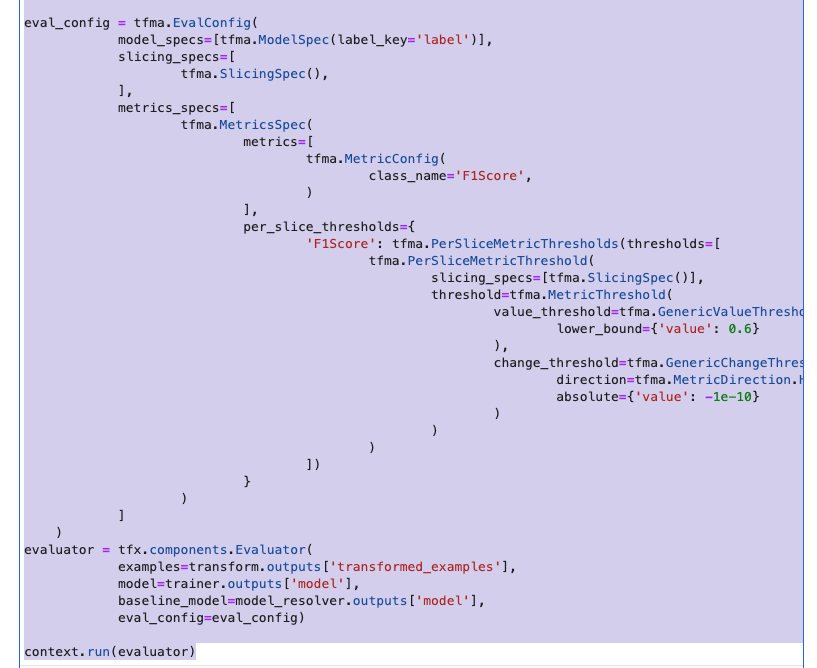

#### ExampleGen
EvaluatorではTrainerに渡していないExampleを使いたいので、テスト用にとっておいたjpegから作られたtfrecordをここで指定する。

In [122]:
input_base_test = '/home/jupyter/SimpleMLPIpeline/uploadFromGitHub/tfrecord/plantvillage-test-5percent/'

example_gen_for_eval = ImportExampleGen(input_base=input_base_test)
context.run(example_gen_for_eval)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 7
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

#### Evaluator
kerasのF1ScoreはTFMAとの互換性がなく、カスタムメトリクスを実装する必要がある。かつ、カスタムメトリクスはmodel.compile()のmetrics引数に渡して、eval_configではtfma.metrics.default_binary_classification_specs()を使う。
と思ったが、結局eval_configでもカスタムメトリクスを使う必要があるらしい。
この場合、もうどうしたらいいんですかね。よくわかりません。ということで、おとなしくAUCを使う。
じゃあ最初からTrainerのmetricsもAUCでいいんじゃないか。ほんとそれ。

結局、Trainerに渡すカスタムメトリクスとEvaluatorに渡すカスタムメトリクスは別のようです。

あと、ImportExampleGenをテスト用データについても動かして、そちらをEvaluatorに渡すことでData Leakageを防ぐ。

In [123]:

# eval_config = tfma.EvalConfig(
#             model_specs=[tfma.ModelSpec(label_key='label')],
#             slicing_specs=[
#                     tfma.SlicingSpec(),
#             ],
#             metrics_specs=[
#                     tfma.MetricsSpec(per_slice_thresholds={
#               'auc':
#                   tfma.PerSliceMetricThresholds(thresholds=[
#                       tfma.PerSliceMetricThreshold(
#                           slicing_specs=[tfma.SlicingSpec()],
#                           threshold=tfma.MetricThreshold(
#                               value_threshold=tfma.GenericValueThreshold(
#                                    lower_bound={'value': 0.6}),
#                               # Change threshold will be ignored if there is no
#                               # baseline model resolved from MLMD (first run).
#                               change_threshold=tfma.GenericChangeThreshold(
#                                   direction=tfma.MetricDirection.HIGHER_IS_BETTER,
#                                   absolute={'value': -5e-1}))
#                       )]),
#                     })
#             ]
#     )

# eval_config = tfma.EvalConfig(
#             model_specs=[tfma.ModelSpec(label_key='label')],
#             slicing_specs=[
#                     tfma.SlicingSpec(),
#             ],
#             metrics_specs=[
#                     tfma.MetricsSpec(
#                             metrics=[
#                                     tfma.MetricConfig(
#                                             class_name='AUC',
#                                     )
#                             ],
#                             per_slice_thresholds={
#                                     'auc': tfma.PerSliceMetricThresholds(thresholds=[
#                                             tfma.PerSliceMetricThreshold(
#                                                     slicing_specs=[tfma.SlicingSpec()],
#                                                     threshold=tfma.MetricThreshold(
#                                                             value_threshold=tfma.GenericValueThreshold(
#                                                                     lower_bound={'value': 0.0}
#                                                             ),
#                                                             change_threshold=tfma.GenericChangeThreshold(
#                                                                     direction=tfma.MetricDirection.HIGHER_IS_BETTER,
#                                                                     absolute={'value': -3e-2}
#                                                             )
#                                                     )
#                                             )
#                                     ])
#                             }
#                     )
#             ]
#     )

eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='label')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=tfma.metrics.default_binary_classification_specs()
)

evaluator = tfx.components.Evaluator(
    # examples=example_gen.outputs['examples'],
    examples=example_gen_for_eval.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config
)

context.run(evaluator)

/opt/conda/lib/python3.10/site-packages/tensorflow_model_analysis/metrics/confusion_matrix_metrics.py:528: RuntimeWarning: invalid value encountered in divide
  prec_slope = dtp / np.maximum(dp, 0)
/opt/conda/lib/python3.10/site-packages/tensorflow_model_analysis/metrics/confusion_matrix_metrics.py:532: RuntimeWarning: divide by zero encountered in divide
  p[:num_thresholds - 1] / np.maximum(p[1:], 0), np.ones_like(p[1:]))
/opt/conda/lib/python3.10/site-packages/tensorflow_model_analysis/metrics/confusion_matrix_metrics.py:532: RuntimeWarning: invalid value encountered in divide
  p[:num_thresholds - 1] / np.maximum(p[1:], 0), np.ones_like(p[1:]))
/opt/conda/lib/python3.10/site-packages/tensorflow_model_analysis/metrics/binary_confusion_matrices.py:155: RuntimeWarning: invalid value encountered in divide
  false_omission_rate = fn / predicated_negatives


ExecutionResult(
    component_id: Evaluator
    execution_id: 8
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

##### evaluatorのartifactを確認する。

In [124]:
evaluation_uri = evaluator.outputs['evaluation']._artifacts[0].uri
evaluation_uri

'/var/tmp/tfx-testing-evaluator-customf1score-362r3ff9/Evaluator/evaluation/8'

In [125]:
evaluation_uri = evaluator.outputs['evaluation']._artifacts[0].uri
evaluation_result = tfma.load_eval_result(evaluation_uri)
type(evaluation_result)

tensorflow_model_analysis.view.view_types.EvalResult

In [126]:
evaluation_result

EvalResult(slicing_metrics=[((), {'': {'': {'loss': {'doubleValue': 0.33200231194496155}, 'example_count': {'doubleValue': 137.0}, 'weighted_example_count': {'doubleValue': 137.0}, 'binary_accuracy': {'doubleValue': 0.8540145985401459}, 'auc': {'doubleValue': 0.9598723210214318}, 'auc_precison_recall': {'doubleValue': 0.9628029119641883}, 'precision': {'doubleValue': 0.9583333333333334}, 'recall': {'doubleValue': 0.8023255813953488}, 'mean_label': {'doubleValue': 0.6277372262773723}, 'mean_prediction': {'doubleValue': 0.5167423598400324}, 'calibration': {'doubleValue': 0.8231825964893539}}}})], plots=[((), {'': {'': {'calibrationHistogramBuckets': {'buckets': [{'lowerThresholdInclusive': '-Infinity', 'numWeightedExamples': 0.0, 'totalWeightedLabel': 0.0, 'totalWeightedRefinedPrediction': 0.0}, {'upperThresholdExclusive': 0.001, 'numWeightedExamples': 0.0, 'totalWeightedLabel': 0.0, 'totalWeightedRefinedPrediction': 0.0}, {'lowerThresholdInclusive': 0.001, 'upperThresholdExclusive': 0.0

In [131]:
evaluation_result.get_metrics_for_all_slices()[()]['auc']['doubleValue']

0.9598723210214318

In [135]:
import tensorflow_model_analysis as tfma
tfma.view.render_plot(evaluation_result)

PlotViewer(config={'sliceName': 'Overall', 'metricKeys': {'calibrationPlot': {'metricName': 'calibrationHistog…

In [140]:
blessing_uri = evaluator.outputs['blessing']._artifacts[0].uri
uri = str(blessing_uri)
uri

'/var/tmp/tfx-testing-evaluator-customf1score-362r3ff9/Evaluator/blessing/8'

In [141]:
!ls {uri}

In [81]:
!ls '/var/tmp' | grep 'tfx-interactive-2024-10-30'

tfx-interactive-2024-10-30T08_42_47.800723-cs5m6b3t
tfx-interactive-2024-10-30T10_59_05.227986-ikrjxbbt
tfx-interactive-2024-10-30T15_38_05.217245-45syrr2s
tfx-interactive-2024-10-30T16_42_15.414434-z91ob2_0
tfx-interactive-2024-10-30T16_43_12.257237-770bw2az
tfx-interactive-2024-10-30T16_48_11.505628-08d41pn7
tfx-interactive-2024-10-30T16_50_44.673381-m_csi_qe
tfx-interactive-2024-10-30T16_50_51.868399-kg5b6__t
tfx-interactive-2024-10-30T16_57_42.828755-jfeb3frm
tfx-interactive-2024-10-30T17_00_59.919473-xcvr34dp
tfx-interactive-2024-10-30T19_02_36.951375-fui0dxkm


In [132]:
!ls '/var/tmp/tfx-testing-evaluator-customf1score-362r3ff9'

Evaluator	  SchemaGen	 Trainer    _wheels
ImportExampleGen  StatisticsGen  Transform  metadata.sqlite


In [89]:
previous_uri = '/var/tmp/tfx-interactive-2024-10-30T19_02_36.951375-fui0dxkm/Evaluator/evaluation/9'
evaluation_result = tfma.load_eval_result(evaluation_uri)
evaluation_result.get_metrics_for_all_slices()[()]['auc']['doubleValue']

0.9687642498860008

#### just test Pusher

In [18]:
from tfx.components import Pusher
pusher = Pusher(
    model=trainer.outputs['model'],
    push_destination=tfx.proto.PushDestination(
        filesystem=tfx.proto.PushDestination.Filesystem(
            base_directory=_serving_model_dir)))
context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 6
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [20]:
push_uri = pusher.outputs['pushed_model'].get()[0].uri
model = tf.saved_model.load(push_uri)

for item in model.signatures.items():
    print(item)

('serving_default', <ConcreteFunction (*, examples: TensorSpec(shape=(None,), dtype=tf.string, name='examples')) -> Dict[['output_0', TensorSpec(shape=(None, 10), dtype=tf.float32, name='output_0')]] at 0x7F1CBFA75450>)


### Push model into Vertex AI Predictions

In [136]:
GOOGLE_CLOUD_PROJECT = 'mlpipelineportfolio'         # <--- ENTER THIS
# GOOGLE_CLOUD_PROJECT_NUMBER = '564758604505'  # <--- ENTER THIS
GOOGLE_CLOUD_REGION = 'asia-northeast1'          # <--- ENTER THIS
GCS_BUCKET_NAME = 'mlpipelineportfolio_bucket_01'              # <--- ENTER THIS

if not (GOOGLE_CLOUD_PROJECT and GOOGLE_CLOUD_REGION and GCS_BUCKET_NAME):
    from absl import logging
    logging.error('Please set all required parameters.')

In [137]:
# PIPELINE_NAME = 'penguin-vertex-training'

# Path to various pipeline artifact.
# PIPELINE_ROOT = 'gs://{}/pipeline_root/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' Python module.
# MODULE_ROOT = 'gs://{}/pipeline_module/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Paths for users' data.
# DATA_ROOT = 'gs://{}/data/{}'.format(GCS_BUCKET_NAME, PIPELINE_NAME)

# Name of Vertex AI Endpoint.
ENDPOINT_NAME = 'prediction-Mdl01'

# print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))

In [142]:
# NEW: Configuration for pusher.
vertex_serving_spec = {
  'project_id': GOOGLE_CLOUD_PROJECT,
  'endpoint_name': ENDPOINT_NAME,
  # Remaining argument is passed to aiplatform.Model.deploy()
  # See https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api#deploy_the_model
  # for the detail.
  #
  # Machine type is the compute resource to serve prediction requests.
  # See https://cloud.google.com/vertex-ai/docs/predictions/configure-compute#machine-types
  # for available machine types and accelerators.
  'machine_type': 'n1-standard-4',
}

# Vertex AI provides pre-built containers with various configurations for
# serving.
# See https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
# for available container images.
serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest'
# if use_gpu:
#     vertex_serving_spec.update({
#         'accelerator_type': 'NVIDIA_TESLA_K80',
#         'accelerator_count': 1
#     })
# serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-6:latest'

# NEW: Pushes the model to Vertex AI.
pusher = tfx.extensions.google_cloud_ai_platform.Pusher(
  model=trainer.outputs['model'],
  custom_config={
      tfx.extensions.google_cloud_ai_platform.ENABLE_VERTEX_KEY:
          True,
      tfx.extensions.google_cloud_ai_platform.VERTEX_REGION_KEY:
          GOOGLE_CLOUD_REGION,
      tfx.extensions.google_cloud_ai_platform.VERTEX_CONTAINER_IMAGE_URI_KEY:
          serving_image,
      tfx.extensions.google_cloud_ai_platform.SERVING_ARGS_KEY:
        vertex_serving_spec,
  })

In [143]:
context.run(pusher)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/564758604505/locations/asia-northeast1/models/598969954347253760/operations/853612999049478144
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/564758604505/locations/asia-northeast1/models/598969954347253760@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/564758604505/locations/asia-northeast1/models/598969954347253760@1')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/564758604505/locations/asia-northeast1/endpoints/7316401059872636928
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/564758604505/locations/asia-northeast1/endpoints/7316401059872636928/operations/214101851962867712
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/564758604505/locati

ExecutionResult(
    component_id: Pusher
    execution_id: 10
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

### 以下のチュートリアルを参照してオンライン予測を送る
https://cloud.google.com/vertex-ai/docs/predictions/get-online-predictions?hl=ja#online_predict_custom_trained-python_vertex_ai_sdk

In [1]:
import base64

ENDPOINT_ID = '5630365949375807488'
GOOGLE_CLOUD_REGION = 'asia-northeast1'

In [2]:
from google.cloud import aiplatform

def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    print(prediction)
    return prediction

#### 複数のjpegからなるExamplesを送ってみる。

In [7]:
image_path_0_01 = '/home/jupyter/ds_SimpleMLPipeline/plantdisease-train-test-split/plantvillage/PlantVillage/test-5percent/[0]/000bf685-b305-408b-91f4-37030f8e62db___GH_HL Leaf 308.1.JPG'
image_path_1_01 = '/home/jupyter/ds_SimpleMLPipeline/plantdisease-train-test-split/plantvillage/PlantVillage/test-5percent/[1]/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.JPG'
image_path_0_02 = '/home/jupyter/ds_SimpleMLPipeline/plantdisease-train-test-split/plantvillage/PlantVillage/test-5percent/[0]/0d932b2a-584e-4971-8590-70c5f0a049cf___RS_HL 9739.JPG'
image_path_0_03 = '/home/jupyter/ds_SimpleMLPipeline/plantdisease-train-test-split/plantvillage/PlantVillage/test-5percent/[0]/c40b106b-14bf-4af2-88b5-51182169d548___RS_HL 0298.JPG'
image_path_0_04 = '/home/jupyter/ds_SimpleMLPipeline/plantdisease-train-test-split/plantvillage/PlantVillage/test-5percent/[0]/fa421fcb-ba24-4562-bf15-0ba854194d70___JR_HL 7641.JPG'


In [8]:
def create_example(image_path):
    features = {
        'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
            value=[
                tf.io.read_file(image_path).numpy()
            ])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    examples = example_proto.SerializeToString()
    return base64.b64encode(examples).decode()

instances = [
    {
        'b64': create_example(image_path_0_01),
    },
    {
        'b64': create_example(image_path_0_02),
    },
    {
        'b64': create_example(image_path_0_03),
    },
    {
        'b64': create_example(image_path_0_04),
    }
]

result = endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[0.0499238968], [0.356966138], [0.671953857], [0.0270293057]], deployed_model_id='6346684580732338176', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/2429683202873360384', explanations=None)


これで行けたようです。

In [1]:
import tensorflow as tf
import base64
from google.cloud import aiplatform

def endpoint_predict_sample(
    project: str, location: str, instances: list, endpoint: str
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint(endpoint)

    prediction = endpoint.predict(instances=instances)
    print(prediction)
    return prediction

2024-10-13 05:16:58.312891: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 05:16:59.136308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 05:16:59.136426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 05:16:59.308264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 05:16:59.655568: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 05:16:59.660288: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
print(tf.__version__)
print(aiplatform.__version__)

2.15.1
1.67.1


In [7]:
image_path_00 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[0]/mnist_115.jpg'
image_path_06 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[6]/mnist_125.jpg'
image_path_08 = '/home/jupyter/Poc/dataset/cifar10_images_subsampled_01/[8]/mnist_193.jpg'

In [8]:
ENDPOINT_ID = '1706270522494418944'
GOOGLE_CLOUD_REGION = 'asia-northeast1'

In [9]:
def create_example(image_path):
    features = {
        'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
            value=[
                tf.io.read_file(image_path).numpy()
            ])),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    examples = example_proto.SerializeToString()
    return base64.b64encode(examples).decode()

instances = [
    {
        'b64': create_example(image_path_00),
    },
    {
        'b64': create_example(image_path_06),
    },
    {
        'b64': create_example(image_path_08)
    }
]

result = endpoint_predict_sample(project='mlpipelineportfolio',
                        location=GOOGLE_CLOUD_REGION,
                        instances=instances,
                        endpoint=ENDPOINT_ID)

Prediction(predictions=[[10.6939478, 4.9314127, 2.70324087, 0.565113544, 2.82545447, 0.949488, 0.413452327, 3.82796669, 5.77344179, 5.83714342], [2.57734847, 1.32579911, 1.76354098, 8.5299921, 4.34581184, 2.65882111, 10.4190025, -0.999995351, 0.847578228, 1.02926636], [3.50385213, 3.03335047, 1.78210187, 0.028274402, 4.0143466, 0.322649091, 2.66440201, 2.57147121, 11.3042545, 6.13295412]], deployed_model_id='5360818474803265536', metadata=None, model_version_id='1', model_resource_name='projects/564758604505/locations/asia-northeast1/models/5560529368825987072', explanations=None)


問題なし。

In [6]:
!pip freeze | grep '^b'

babel==2.16.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.9.0
bleach==6.1.0
blessed==1.20.0
boltons @ file:///home/conda/feedstock_root/build_artifacts/boltons_1711936407380/work
bq_stats @ file:///tmp/environments/base/pip/packages/bq_stats


base64は標準パッケージらしい。

In [1]:
import subprocess

In [2]:
repo_url = "https://github.com/bipodboqid/SimpleMLPipeline.git"

# git ls-remoteでリモートリポジトリの最新のコミットを取得
result = subprocess.run(["git", "ls-remote", repo_url, "main"], stdout=subprocess.PIPE)
latest_commit = result.stdout.decode('utf-8').split()[0]
print(f"Latest commit hash: {latest_commit}")

Latest commit hash: 25150124fa761986d9d43ccc7f15ef91837d3ebb


In [1]:
import requests

def get_latest_commit(owner, repo, branch='main'):
    url = f"https://api.github.com/repos/{owner}/{repo}/commits/{branch}"
    response = requests.get(url)
    if response.status_code == 200:
        commit_data = response.json()
        return commit_data['sha']
    else:
        raise Exception(f"Failed to get latest commit: {response.status_code}")

def main(request):
    # 例: GitHubのリポジトリ所有者とリポジトリ名
    owner = "your-username"
    repo = "your-repository"
    latest_commit = get_latest_commit(owner, repo)
    return f"Latest commit hash: {latest_commit}"

In [2]:
get_latest_commit('bipodboqid', 'SimpleMLPipeline')

'25150124fa761986d9d43ccc7f15ef91837d3ebb'